## Постановка задачи

Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

## Описание данных

В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

**train.csv:**

- user_id - уникальный id пользователя
- order_completed_at - дата заказа
- cart - список уникальных категорий (category_id), из которых состоял заказ

В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

**sample_submission.csv:**

Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

- id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
- target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

## Предварительная обработка данных

In [1]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка данных в DataFrame
train_data_df = pd.read_csv('train.csv')
sub_df = pd.read_csv('sample_submission.csv')

In [3]:
train_data_df.head(10)

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
5,2,2015-03-22 09:25:46,82
6,2,2015-03-22 09:25:46,134
7,2,2015-03-22 09:25:46,16
8,2,2015-03-22 09:25:46,409
9,2,2015-03-22 09:25:46,384


In [4]:
train_data_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   user_id             3123064 non-null  int64 
 1   order_completed_at  3123064 non-null  object
 2   cart                3123064 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 71.5+ MB


In [5]:
sub_df.head(10)

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0
5,0;398,0
6,0;399,1
7,0;401,0
8,0;402,0
9,0;20,0


In [6]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


In [7]:
# Преобразуем дату в train_data_df во временную отметку

train_data_df['order_completed_at'] = pd.to_datetime(train_data_df['order_completed_at'])

In [8]:
# Для удобства разделим колонку id из sub_df на user_id и item_id

sub_df_split_id = sub_df.assign(
    user_id=sub_df["id"].apply(lambda x: x.split(";")[0]).astype(np.int64),
    item_id=sub_df["id"].apply(lambda x: x.split(";")[1]).astype(np.int64)
)[['user_id','item_id', 'target']]

sub_df_split_id.head(10)

,user_id,item_id,target
0,0,133,0
1,0,5,1
2,0,10,0
3,0,396,1
4,0,14,0
5,0,398,0
6,0,399,1
7,0,401,0
8,0,402,0
9,0,20,0


In [9]:
train_data_df.describe()

,user_id,order_completed_at,cart
count,3.123064e+06,3123064,3.123064e+06
mean,7.253373e+03,2020-04-09 01:17:00.182836992,2.273235e+02
min,0.000000e+00,2015-03-22 09:25:46,0.000000e+00
25%,2.884000e+03,2020-02-03 06:03:43,4.200000e+01
50%,6.055000e+03,2020-05-19 06:35:20,1.460000e+02
75%,1.117200e+04,2020-07-14 04:50:22,3.990000e+02
max,1.999900e+04,2020-09-03 23:45:45,8.800000e+02
std,5.337838e+03,NaN,2.112867e+02


In [10]:
users_data = train_data_df['user_id'].unique().tolist()
items_data = train_data_df['cart'].unique().tolist()
num_orders_for_each_user = train_data_df.groupby('user_id')['order_completed_at'].nunique().tolist()

users_sub = sub_df_split_id['user_id'].unique().tolist()
items_sub = sub_df_split_id['item_id'].unique().tolist()

print(f'Количество уникальных пользователей в тренировочном наборе {len(users_data)}')
print(f'Количество уникальных пользователей в сабмите {len(users_sub)}')
print(f'Количество уникальных категорий в тренировочном наборе {len(items_data)}')
print(f'Количество уникальных категорий в сабмите {len(items_sub)}')
print(f'Количество уникальных заказов в тренировочном наборе {sum(num_orders_for_each_user)}')
print(f'Множество несовпадающих категорий в наборах данных {set(items_data) - set(items_sub)}')

Количество уникальных пользователей в тренировочном наборе 20000
Количество уникальных пользователей в сабмите 13036
Количество уникальных категорий в тренировочном наборе 881
Количество уникальных категорий в сабмите 858
Количество уникальных заказов в тренировочном наборе 209406
Множество несовпадающих категорий в наборах данных {769, 771, 777, 782, 667, 795, 543, 548, 549, 38, 556, 184, 188, 320, 321, 466, 726, 864, 488, 753, 633, 765, 510}


In [11]:
# Уберем пользователей из тренировочного набора, которые ничего не заказали после даты отсечения (отсутствующие в сабмите)

train_data_df_clean = train_data_df.loc[train_data_df['user_id'].isin(set(users_sub))]

In [12]:
# Повторно оценим количественные показатели

users_data_clean = train_data_df_clean['user_id'].unique().tolist()
items_data_clean = train_data_df_clean['cart'].unique().tolist()
num_orders_for_each_user_clean = train_data_df_clean.groupby('user_id')['order_completed_at'].nunique().tolist()

users_sub = sub_df_split_id['user_id'].unique().tolist()
items_sub = sub_df_split_id['item_id'].unique().tolist()

print(f'Количество уникальных пользователей в тренировочном наборе {len(users_data_clean)}')
print(f'Количество уникальных пользователей в сабмите {len(users_sub)}')
print(f'Количество уникальных категорий в тренировочном наборе {len(items_data_clean)}')
print(f'Количество уникальных категорий в сабмите {len(items_sub)}')
print(f'Количество уникальных заказов в тренировочном наборе {sum(num_orders_for_each_user_clean)}')
print(f'Множество несовпадающих категорий в наборах данных {set(items_data_clean) - set(items_sub)}')

Количество уникальных пользователей в тренировочном наборе 13036
Количество уникальных пользователей в сабмите 13036
Количество уникальных категорий в тренировочном наборе 858
Количество уникальных категорий в сабмите 858
Количество уникальных заказов в тренировочном наборе 160557
Множество несовпадающих категорий в наборах данных set()


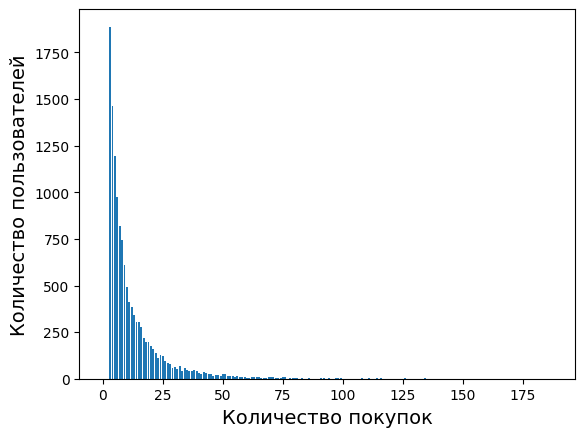

In [13]:
# Распределение пользователей по количеству совершенных ими покупок

plt.bar(range(max(num_orders_for_each_user_clean) + 1), np.bincount(num_orders_for_each_user_clean))
plt.ylabel('Количество пользователей', size = 14)
plt.xlabel('Количество покупок', size = 14)
plt.show()

In [14]:
print(f'Максимальное число покупок, совершенные одним пользователем {max(num_orders_for_each_user_clean)}')
print(f'Минимальнео число покупок, совершенные одним пользователем {min(num_orders_for_each_user_clean)}')

Максимальное число покупок, совершенные одним пользователем 187
Минимальнео число покупок, совершенные одним пользователем 3


In [15]:
# Взглянем более детально на распределение пользователей по количеству покупок

np.bincount(num_orders_for_each_user_clean), max(num_orders_for_each_user_clean)

(array([   0,    0,    0, 1888, 1465, 1195,  973,  817,  742,  611,  490,
         412,  383,  344,  305,  306,  279,  218,  197,  196,  177,  160,
         138,  112,  125,  120,   94,   85,   80,   60,   61,   54,   66,
          44,   56,   48,   44,   43,   48,   39,   32,   26,   34,   31,
          25,   24,   16,   20,   20,   13,   26,   24,   12,   15,   14,
          10,   13,    9,   10,    8,    5,    6,    9,   10,    7,    7,
           2,    3,    5,   10,   11,    7,    3,    2,    4,    8,    8,
           0,    5,    4,    2,    2,    0,    3,    0,    1,    2,    1,
           1,    0,    1,    3,    3,    1,    2,    1,    0,    6,    2,
           2,    0,    1,    0,    0,    1,    0,    0,    1,    2,    0,
           0,    3,    0,    1,    2,    0,    2,    0,    0,    1,    1,
           0,    0,    0,    1,    1,    2,    1,    0,    0,    0,    0,
           0,    1,    2,    0,    0,    1,    0,    0,    0,    0,    0,
           0,    0,    1,    0,    0, 

In [16]:
# Сагрегируем некоторые данные по пользователям

agg_df = train_data_df_clean.groupby("user_id").agg(
    num_ord=pd.NamedAgg(column="order_completed_at", aggfunc="nunique"), # Количество заказов пользователя
    num_uniq_items=pd.NamedAgg(column="cart", aggfunc="nunique"), # Количество уникальных категорий, заказанных пользователем
    sum_count_items=pd.NamedAgg(column="cart", aggfunc="count"), # Суммарное количество категорий заказанных пользователем
)
agg_df = agg_df.assign(
    mean_count_items = (agg_df['sum_count_items'] / agg_df['num_ord']).round(2), # Среднее количестов категорий на заказ
    mean_uniq_items = (agg_df['num_uniq_items'] / agg_df['num_ord']).round(2) # Среднее количестов уникальных категорий на заказ
).reset_index()

agg_df.head(10)

,user_id,num_ord,num_uniq_items,sum_count_items,mean_count_items,mean_uniq_items
0,0,3,36,44,14.67,12.00
1,1,9,20,37,4.11,2.22
2,3,7,38,62,8.86,5.43
3,4,8,50,112,14.00,6.25
4,5,15,76,116,7.73,5.07
5,7,11,59,95,8.64,5.36
6,8,8,146,299,37.38,18.25
7,9,46,74,369,8.02,1.61
8,10,3,40,47,15.67,13.33
9,11,36,69,247,6.86,1.92


In [17]:
agg_df.describe()

,user_id,num_ord,num_uniq_items,sum_count_items,mean_count_items,mean_uniq_items
count,13036.000000,13036.000000,13036.000000,13036.000000,13036.000000,13036.000000
mean,10172.023780,12.316431,60.635855,183.772400,14.547085,6.899815
std,5860.170178,13.299200,33.429025,223.413977,6.334524,3.613636
min,0.000000,3.000000,1.000000,3.000000,1.000000,0.030000
25%,5108.500000,4.000000,36.000000,56.000000,10.330000,4.287500
50%,10193.500000,8.000000,55.000000,108.000000,13.830000,6.330000
75%,15281.500000,15.000000,80.000000,221.000000,18.000000,8.890000
max,19998.000000,187.000000,250.000000,3508.000000,64.400000,31.200000


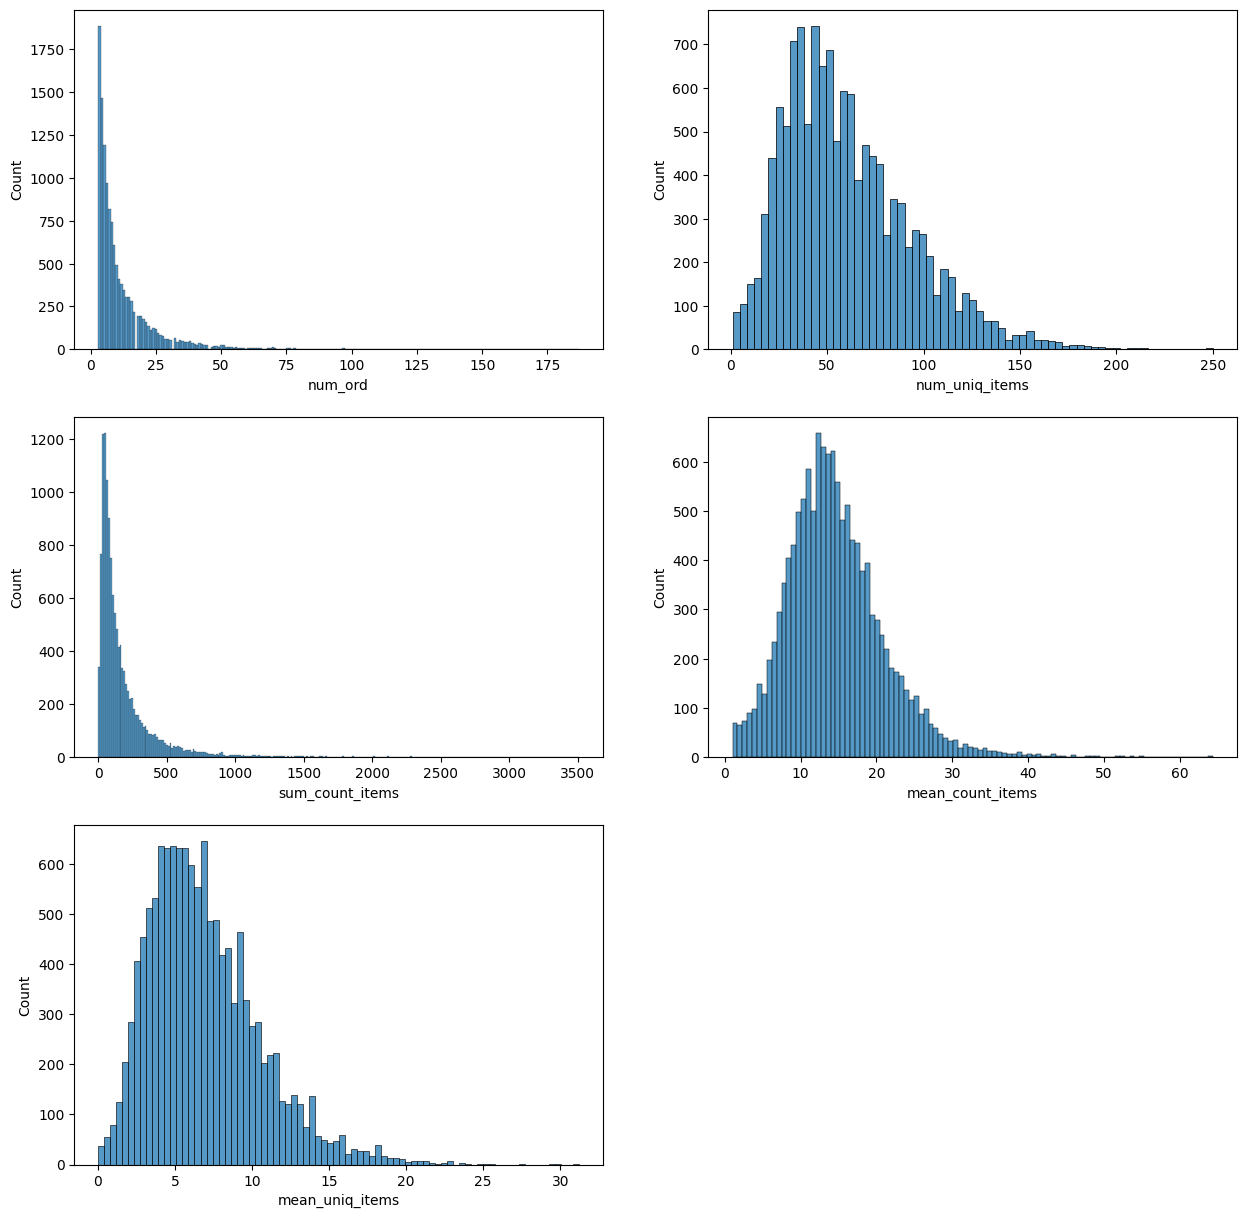

In [18]:
# Оценим распределение данных величин

fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(agg_df.columns[1:]):
    ax = plt.subplot(3,2,i+1)
    sns.histplot(data=agg_df, x = col, ax=ax)
plt.show()

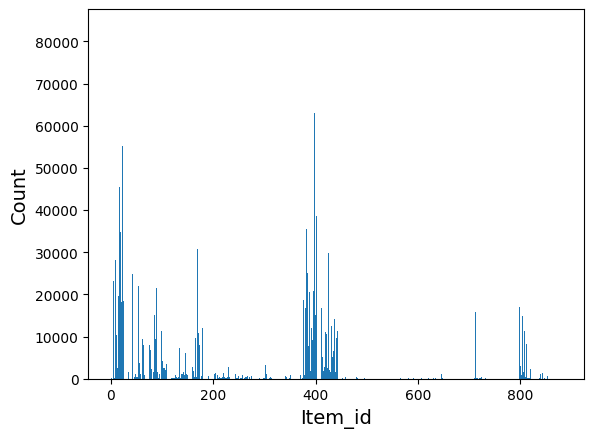

In [19]:
# Оценим наиболее популярные товары

most_items = (
    train_data_df_clean.groupby("cart")["order_completed_at"]
    .nunique()
    .to_frame()
    .reset_index()
)
most_items.rename({"order_completed_at": "count"}, axis=1, inplace=True)
plt.bar(x=most_items["cart"], height=most_items["count"])
plt.ylabel("Count", size=14)
plt.xlabel("Item_id", size=14)
plt.show()

In [20]:
most_items.sort_values('count', ascending=False, inplace=True)
most_items.head(10)

,cart,count
56,57,83493
14,14,72035
60,61,70321
393,398,63066
23,23,55145
22,22,52305
83,84,52303
404,409,46529
17,17,45477
54,55,38597


In [21]:
most_items.tail(10)

,cart,count
735,750,1
795,817,1
559,571,1
736,751,1
737,752,1
501,508,1
561,573,1
565,577,1
566,578,1
36,36,1


In [22]:
# Сагрегируем корзины пользователей для каждого заказа

baskets_df =train_data_df_clean.groupby(["user_id", "order_completed_at"])[
    "cart"
].unique().to_frame().sort_values(
    ["user_id", "order_completed_at"], ascending=[True, False]
).rename({"cart" : 'basket'}, axis=1).reset_index()

baskets_df.head(10)

,user_id,order_completed_at,basket
0,0,2020-09-02 07:38:25,"[803, 170, 84, 61, 440, 57, 55, 401, 398, 399,..."
1,0,2020-08-24 08:55:32,"[133, 5, 26, 10, 382, 14, 22, 41, 25, 441, 411..."
2,0,2020-07-19 09:59:17,"[20, 82, 441, 57, 14, 405, 430, 379]"
3,1,2020-07-14 10:20:58,"[88, 302, 803, 307, 54, 55, 14, 169, 149]"
4,1,2020-05-24 11:13:59,"[798, 55, 14, 170, 171, 169]"
5,1,2020-04-30 17:45:22,[55]
6,1,2020-04-14 01:31:20,"[55, 798, 812]"
7,1,2020-03-29 13:26:49,"[55, 169, 88]"
8,1,2020-03-02 13:43:20,"[23, 14, 231, 88, 19, 812, 55]"
9,1,2020-02-06 22:46:55,[55]


In [23]:
# Для тестового набора отберем последние заказы каждого пользователя

data = {'user_id' : [], 'basket': []}

for user_id in baskets_df['user_id'].unique():
    data['user_id'].append(user_id)
    data['basket'].append(set(baskets_df.loc[baskets_df['user_id'] == user_id]['basket'].iloc[0]))
    
last_basket_df = pd.DataFrame(data)

In [24]:
last_basket_df.head(10)

,user_id,basket
0,0,"{803, 169, 170, 398, 399, 401, 84, 55, 440, 57..."
1,1,"{803, 169, 302, 14, 307, 149, 54, 55, 88}"
2,3,"{64, 41, 43, 14, 92, 142, 17, 19, 179, 22, 57,..."
3,4,"{98, 409, 430, 398, 400, 19, 84, 54, 87, 57, 29}"
4,5,"{833, 834, 842, 848, 831}"
5,7,"{0, 5, 230, 393, 16, 20, 22, 90, 379}"
6,8,"{387, 5, 17, 21, 430, 57, 61, 198, 208, 209, 8..."
7,9,"{425, 42, 394, 14, 25}"
8,10,"{387, 389, 392, 398, 14, 15, 17, 402, 19, 404,..."
9,11,"{169, 810, 171, 9, 403, 21, 55, 23, 410}"


In [25]:
# Определим функцию, возвращающую наличие категории товара в корзине

def get_target(row):
    if row['item_id'] in row['basket']:
        return 1
    else:
        return 0

In [26]:
test_df = sub_df_split_id.copy().drop(columns=["target"])
test_df = test_df.merge(last_basket_df, on='user_id')
test_df['target'] = test_df.apply(get_target, axis=1)
test_df.drop(columns=['basket'], inplace=True)

In [27]:
test_df.head(10)

,user_id,item_id,target
0,0,133,0
1,0,5,0
2,0,10,0
3,0,396,0
4,0,14,0
5,0,398,1
6,0,399,1
7,0,401,1
8,0,402,0
9,0,20,0


In [28]:
# В качестве baseline модели просто будем назначать 1 всем товарам,
# купленным не менее чем в половине покупок конткретного пользователя

# Посчитаем частоту покупок каждого товара у каждого пользователя

item_count_df = (
    train_data_df_clean.groupby(["user_id", "cart"])
    .count()
    .unstack()["order_completed_at"]
    .reset_index().fillna(0).astype(np.int16)
)
item_count_df

cart,user_id,0,1,2,3,4,5,6,7,8,...,871,872,873,874,875,876,877,878,879,880
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13031,19994,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13032,19995,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13033,19996,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13034,19997,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
baseline_df = test_df.copy()
baseline_df = (
    baseline_df.merge(agg_df[["user_id", "num_ord"]], on="user_id")
    .merge(last_basket_df, on="user_id")
    .merge(item_count_df, on="user_id")
)

In [30]:
def get_baseline(row):
    if row['item_id'] in row['basket'] and row[row['item_id']] - 1 > (row['num_ord'] - 1) / 2:
        return 1
    elif row['item_id'] not in row['basket'] and row[row['item_id']] > (row['num_ord'] - 1) / 2:
        return 1
    else:
        return 0

In [31]:
drop_columns = baseline_df.columns[3:] 
baseline_df['predict'] = baseline_df.apply(get_baseline, axis=1)
baseline_df.drop(columns=drop_columns, inplace=True)
baseline_df

,user_id,item_id,target,predict
0,0,133,0,0
1,0,5,0,0
2,0,10,0,0
3,0,396,0,0
4,0,14,0,1
...,...,...,...,...
790444,19998,26,0,0
790445,19998,31,0,0
790446,19998,29,0,0
790447,19998,798,1,0


In [32]:
# Определим f-меру для базовой модели

from sklearn.metrics import f1_score

score_baseline = f1_score(baseline_df['target'], baseline_df['predict'])
round(score_baseline, 5)

0.32832

 Как видно уже такая модель относительно неплохо предсказывает корзину покупателя. Возможно, если варьировать порог отсечения, эта модель еще приблизится к показателю 0.487. Однако, такая модель использует примитивные паттерны покупателей и не определяет никаких взаимосвязей между разными продуктами или разными пользователями. Попробуем определить более сложную модель.

В данной постановке задачи требуется, по-сути, разработать RecSys модель. Однако, традиционные решения, такие как колаборативная фильтрация матричными разложениями, скорее всего будут неэффективными. Это связано с условием, что все пары пользователь-продукт уже существуют. Озвученные же методы полезны для оценки несуществовавших ранее пар пользователь-продукт.

Следует выбирать модель для решения задачи Next-basket-recommendation. Такие модели способны рекомендовать пользователю в том числе те товары, с которыми он уже взаимодействовал. Одной из таких моделей является модель TIFU KNN https://arxiv.org/pdf/2006.00556.pdf. Она достаточно проста в реализации и скорости работы. При этом, количесвто пользователей вполне позволяет хранить информацию о них.

In [33]:
# Сформируем историю корзин дял каждого пользователя в хронологическом порядке. 
# Корзины будут представлены векторами длиной 881, где на метах купленных категорий стоит 1, остальные 0

basket_history = {}

for user in baskets_df['user_id'].unique():
    tmp = np.zeros(881, np.int8)
    for basket in baskets_df['basket'].loc[baskets_df['user_id'] == user].values[1:]:
        cur_array = np.zeros(881, np.int8)
        cur_array[basket] = 1
        tmp = np.vstack((tmp, cur_array))
    basket_history[user] = tmp[1:, :]

In [34]:
basket_history_df = pd.DataFrame([*basket_history.items()], columns=['user_id', 'history'])

In [35]:
# Определим функцию, аккумулирующую историю покупок пользователей с заданным коэффициентом забывания r

def get_user_vector(history, r: float = 0.8):

    cur_hist = history.astype(np.float16)
    cur_r = np.array([r ** j for j in range(cur_hist.shape[0])]).reshape(cur_hist.shape[0], 1)
    cur_hist *= cur_r
    cur_hist = np.sum(cur_hist, axis=0)
    
    return cur_hist

In [36]:
# Аккумулируем историю покупок для каждого пользователя

basket_history_df['accum_hist'] = basket_history_df['history'].apply(get_user_vector)

In [37]:
# Построим матрицу на основе векторов пользователей

users_matrix = np.vstack(basket_history_df['accum_hist'].values)
users_matrix.shape

(13036, 881)

In [38]:
# Определим функцию, которая будет возвращать усредненный вектор от ближайших соседей

from sklearn.neighbors import NearestNeighbors

def get_avg_nn_vector(n_neighbors=100, metric="cosine", matrix=users_matrix):
    model = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, n_jobs=-1)
    model.fit(matrix)
    nn = model.kneighbors(users_matrix, n_neighbors=n_neighbors, return_distance=False)
    
    return np.apply_along_axis(lambda x: matrix[x].mean(axis=0), axis=1, arr=nn)

In [39]:
basket_history_df['avg_nn_vector'] = get_avg_nn_vector().tolist()
basket_history_df['avg_nn_vector'] = basket_history_df['avg_nn_vector'].apply(lambda x: np.array(x))
basket_history_df.head()

,user_id,history,accum_hist,avg_nn_vector
0,0,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.364501953125, 0.0059967041015625, 0.0, 0.0,..."
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0806884765625, 0.0, 0.0, 0.0, 0.0, 0.199951..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.44189453125, 0.01259613037109375, 0.0, 1.93..."
3,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.968, 0.0, 0.0, 0.0...","[0.33544921875, 0.0, 0.0, 0.0, 0.0007100105285..."
4,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.082275390625, 0.0, 0.0, 0.0, 0.0, 0.1258544..."


In [40]:
# Определим функцию, которая возвращает итоговый вектор

def get_comb_vector(row, alf = 0.95):
    return alf * row['accum_hist'] + (1 - alf) * row['avg_nn_vector']

In [41]:
basket_history_df['comb_vector'] = basket_history_df.apply(get_comb_vector, axis=1)
basket_history_df.head()

,user_id,history,accum_hist,avg_nn_vector,comb_vector
0,0,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.364501953125, 0.0059967041015625, 0.0, 0.0,...","[0.018225097656250015, 0.00029983520507812525,..."
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0806884765625, 0.0, 0.0, 0.0, 0.0, 0.199951...","[0.004034423828125004, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.44189453125, 0.01259613037109375, 0.0, 1.93...","[0.02209472656250002, 0.000629806518554688, 0...."
3,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.968, 0.0, 0.0, 0.0...","[0.33544921875, 0.0, 0.0, 0.0, 0.0007100105285...","[0.016772460937500015, 0.0, 0.0, 0.0, 3.550052..."
4,5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.082275390625, 0.0, 0.0, 0.0, 0.0, 0.1258544...","[0.004113769531250004, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [42]:
# Определим функцию, предсказывающую наличие товара в корзине по заданному порогу 
def check(row, threshold = 1):
    return 1 if row['comb_vector'][row['item_id']] > threshold else 0

In [43]:
pred_test_df = test_df.merge(
    basket_history_df[["user_id", "comb_vector"]], how="inner", on="user_id"
)
pred_test_df['predict'] = pred_test_df.apply(check, axis=1)
pred_test_df

,user_id,item_id,target,comb_vector,predict
0,0,133,0,"[0.018225097656250015, 0.00029983520507812525,...",0
1,0,5,0,"[0.018225097656250015, 0.00029983520507812525,...",1
2,0,10,0,"[0.018225097656250015, 0.00029983520507812525,...",0
3,0,396,0,"[0.018225097656250015, 0.00029983520507812525,...",0
4,0,14,0,"[0.018225097656250015, 0.00029983520507812525,...",1
...,...,...,...,...,...
790444,19998,26,0,"[0.014404296875000012, 0.0, 0.0, 0.0, 0.0, 0.0...",0
790445,19998,31,0,"[0.014404296875000012, 0.0, 0.0, 0.0, 0.0, 0.0...",0
790446,19998,29,0,"[0.014404296875000012, 0.0, 0.0, 0.0, 0.0, 0.0...",0
790447,19998,798,1,"[0.014404296875000012, 0.0, 0.0, 0.0, 0.0, 0.0...",0


In [44]:
score = f1_score(pred_test_df['target'], pred_test_df['predict'])
round(score, 5)

0.41355

Качество оценки немного улучшилось, по сравнению с базовой моделью. Попробуем оптимизировать параметры

In [45]:
# Определим функцию для оптимизации гиперпараметров модели и сквозную функцию


def fit_predict(data, test_df, **kwargs):
    tmp_basket_history_df = pd.DataFrame(
        [*data.items()], columns=["user_id", "history"]
    )
    tmp_basket_history_df["accum_hist"] = tmp_basket_history_df["history"].apply(
        get_user_vector, r=kwargs["r"]
    )
    tmp_users_matrix = np.vstack(tmp_basket_history_df["accum_hist"].values)
    tmp_basket_history_df["avg_nn_vector"] = get_avg_nn_vector(
        n_neighbors=kwargs["n_neighbors"],
        metric=kwargs["metric"],
        matrix=tmp_users_matrix,
    ).tolist()
    tmp_basket_history_df["avg_nn_vector"] = tmp_basket_history_df[
        "avg_nn_vector"
    ].apply(lambda x: np.array(x))

    tmp_basket_history_df["comb_vector"] = tmp_basket_history_df.apply(
        get_comb_vector, axis=1, alf=kwargs["alf"]
    )
    tmp_pred_test_df = test_df.merge(
        tmp_basket_history_df[["user_id", "comb_vector"]], how="inner", on="user_id"
    )
    tmp_pred_test_df["predict"] = tmp_pred_test_df.apply(
        check, axis=1, threshold=kwargs["threshold"]
    )
    pred = tmp_pred_test_df["predict"]
    return pred


def grid_search(data, test_df, params):
    r_vals = params["r"]
    metrics = params["metric"]
    n_neighbors_val = params["n_neighbors"]
    alf_val = params["alf"]
    threshold_val = params["threshold"]

    col_params = []
    col_score = []

    for r in r_vals:
        for metric in metrics:
            for n_neighbors in n_neighbors_val:
                for alf in alf_val:
                    for threshold in threshold_val:
                        cur_params = {
                            "r": r,
                            "metric": metric,
                            "n_neighbors": n_neighbors,
                            "alf": alf,
                            "threshold": threshold,
                        }
                        col_params.append(cur_params)
                        pred = fit_predict(data, test_df, **cur_params)
                        cur_score = round(f1_score(test_df["target"], pred), 5)
                        col_score.append(cur_score)
                        print(f"Текущие параметры {cur_params} --> f-мера {cur_score}")
    return col_params, col_score

In [148]:
params = {
    "r": [0.8, 0.7, 0.5],
    "metric": ["cosine"],
    "n_neighbors": [100, 300, 500],
    "alf": [0.2, 0.5, 0.9],
    "threshold": [0.9, 1, 1.1],
}

col_params, col_score = grid_search(basket_history, test_df, params=params)

Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.2, 'threshold': 0.9} --> f-мера 0.43576
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.2, 'threshold': 1} --> f-мера 0.43288
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.2, 'threshold': 1.1} --> f-мера 0.42703
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.5, 'threshold': 0.9} --> f-мера 0.42999
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.5, 'threshold': 1} --> f-мера 0.43115
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.5, 'threshold': 1.1} --> f-мера 0.42974
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.9, 'threshold': 0.9} --> f-мера 0.40253
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.9, 'threshold': 1} --> f-мера 0.41574
Текущие параметры {'r': 0.8, 'metric': 'cosine', 'n_neighbors'

In [149]:
score_df = pd.DataFrame({'params': col_params, 'f1-score': col_score})
score_df.sort_values('f1-score', inplace=True, ascending=False)
pd.set_option('display.max_colwidth', 120)
score_df.head(20)

,params,f1-score
0,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.2, 'threshold': 0.9}",0.43576
9,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 300, 'alf': 0.2, 'threshold': 0.9}",0.43542
18,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 500, 'alf': 0.2, 'threshold': 0.9}",0.43508
1,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.2, 'threshold': 1}",0.43288
10,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 300, 'alf': 0.2, 'threshold': 1}",0.43147
13,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 300, 'alf': 0.5, 'threshold': 1}",0.43119
4,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 100, 'alf': 0.5, 'threshold': 1}",0.43115
22,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 500, 'alf': 0.5, 'threshold': 1}",0.43113
19,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 500, 'alf': 0.2, 'threshold': 1}",0.43037
12,"{'r': 0.8, 'metric': 'cosine', 'n_neighbors': 300, 'alf': 0.5, 'threshold': 0.9}",0.43036


Оптимизационный поиск показал, что косинусное расстояние работает лучше, порог срабатывани 1 дает лучшее качество при различных параметрах. Количесвто похожих пользователей в данном случае слабо влияло на метрику. Очевидно, что чем ближе альфа к 1, тем менее значимо влияние похожих пользоватлеей на предсказание

In [47]:
# Обучим модель на полных данных

full_basket_history = {}

for user in baskets_df['user_id'].unique():
    tmp = np.zeros(881, np.int8)
    for basket in baskets_df['basket'].loc[baskets_df['user_id'] == user].values:
        cur_array = np.zeros(881, np.int8)
        cur_array[basket] = 1
        tmp = np.vstack((tmp, cur_array))
    full_basket_history[user] = tmp[1:, :]

In [54]:
# После дополнительного небольшого подбора были определены оптимальные параметры

params = {
    "r": 0.8,
    "metric": "cosine",
    "n_neighbors": 200,
    "alf": 0.6,
    "threshold": 1.2
}

pred = fit_predict(full_basket_history, test_df, **params)

my_sub = sub_df.copy()
my_sub['target'] = pred
my_sub.to_csv('my_sub.csv', sep=',', index=False)